In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import richdem as rd
import rioxarray as rio
import seaborn as sn
from osgeo import gdal

plt.style.use("ggplot")

# DEM Processing

Basic DEM processing using GDAL.

Limited docs here: https://gdal.org/api/python/osgeo.gdal.html#osgeo.gdal.DEMProcessing

In [2]:
def save_array(array, template, out_path, in_ndv, out_ndv, dtype="float32"):
    """Save an array to disk using an existing GeoTiff as a template.

    Args
        array:    Array-like. Values to save.
        template: Obj. Rioxarray dataset with the same dimensions, projection etc.
                  as the dataset you want to save. 'template' will be copied, then
                  values will be overwritten with the values in 'array', and saved
        out_path: Str. Path to output slope GeoTiff
        in_ndv:   Int. Value in 'array' representing no data
        out_ndv:  Int. Value to use for no data in the output grid
        dtype:    Str. Default 'float32'. Rasterio data type. See the list here:
                    https://test2.biogeo.ucdavis.edu/rasterio/_modules/rasterio/dtypes.html

    Returns
        None. Array is saved to disk.
    """
    array = array.copy()
    array[array == in_ndv] = np.nan
    template = template.copy()
    array = array[np.newaxis, ...]
    template.values = array
    template.rio.write_nodata(out_ndv, encoded=True, inplace=True)
    template.rio.to_raster(
        out_path, compress="lzw", BIGTIFF="YES", dtype=dtype, tiled=True
    )

## 1. User input

In [3]:
# Input DEM
dem_path = r"/home/jovyan/shared/common/LJB/svalbard/raster/S0_DTM50.tif"

# Ouput grids
dem_clip_path = r"/home/jovyan/shared/common/LJB/svalbard/raster/S0_DTM50_Clipped.tif"
hil_path = r"/home/jovyan/shared/common/LJB/svalbard/raster/S0_DTM50_Clipped_Hillshade.tif"
slp_path = r"/home/jovyan/shared/common/LJB/svalbard/raster/S0_DTM50_Slope.tif"
asp_path = r"/home/jovyan/shared/common/LJB/svalbard/raster/S0_DTM50_Aspect.tif"
cur_path = r"/home/jovyan/shared/common/LJB/svalbard/raster/S0_DTM50_Curvature.tif"
soa_path = r"/home/jovyan/shared/common/LJB/svalbard/raster/S0_DTM50_SOA.tif"

# Region of interest. Either
# 1. Specify bounding box
crs = "epsg:25833"
minx = 500000
miny = 8660000
maxx = 555000
maxy = 8700000

# Or 2. Specify polygon
cat_shp = r"/home/jovyan/shared/common/LJB/svalbard/vector/svalbard_basins.shp"

# Optionally, buffer polygon to keep some of the surrounding cells
# (float in units of the shapefile CRS)
buffer = None

## 2. DEM

### 2.1. Use bounding box

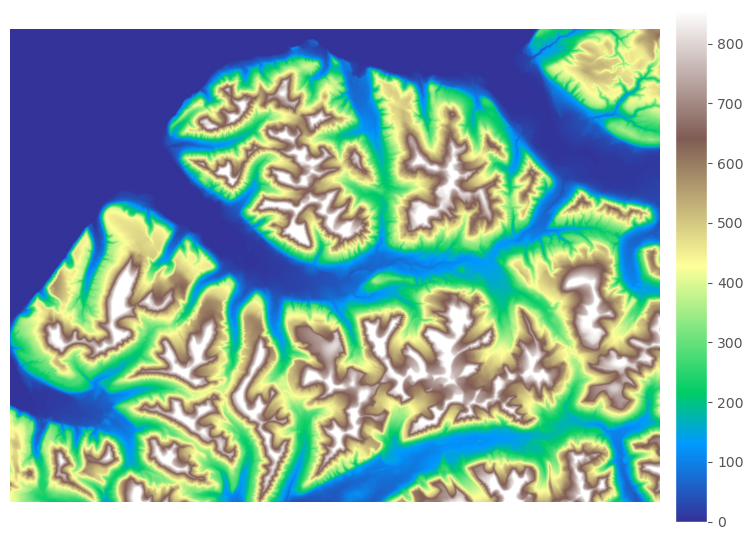

In [4]:
# Clip raw DEM to bounding box
ds = rio.open_rasterio(dem_path)
ds = ds.rio.clip_box(
    minx=minx,
    miny=miny,
    maxx=maxx,
    maxy=maxy,
    crs=crs,
)
ds.rio.to_raster(dem_clip_path)

# Read DEM
dem = rd.LoadGDAL(dem_clip_path)
rd.rdShow(dem, axes=False, cmap="terrain", figsize=(8, 5.5));

### 2.2. Use catchment shapefile

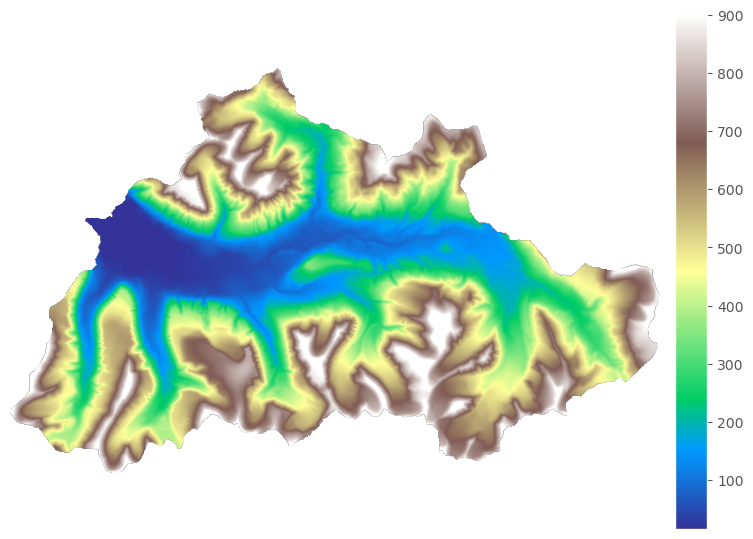

In [5]:
# Get catchment
gdf = gpd.read_file(cat_shp)
gdf = gdf.query("STATION_NA =='Adventelva'")

if buffer:
    gdf.geometry = gdf.buffer(buffer)

# Clip raw DEM to catchment
ds = rio.open_rasterio(dem_path)
ds = ds.rio.clip(
    gdf["geometry"].values,
    gdf.crs,
    all_touched=False,
    drop=True,
    invert=False,
)
ds.rio.to_raster(dem_clip_path)

# Read DEM
dem = rd.LoadGDAL(dem_clip_path)
rd.rdShow(dem, axes=False, cmap="terrain", figsize=(8, 5.5));

## 3. Hillshade

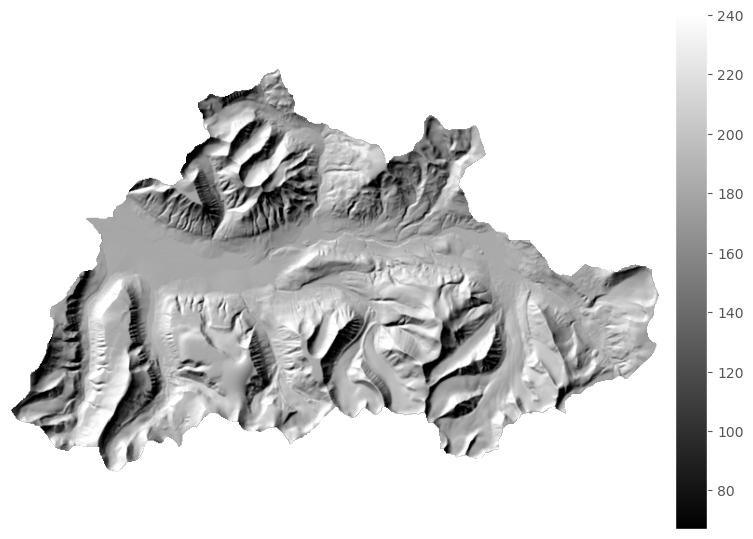

In [6]:
gdal_res = gdal.DEMProcessing(
    hil_path,
    dem_clip_path,
    "hillshade",
    alg="Horn",  # 'Horn' or 'ZevenbergenThorne'
    creationOptions=["compress=lzw", "BIGTIFF=YES", "tiled=True"],
)
gdal_res.FlushCache()
gdal_res = None

hillsh = rd.LoadGDAL(hil_path).astype(float)
rd.rdShow(hillsh, axes=False, cmap="gray", figsize=(8, 5.5));

## 4. Slope

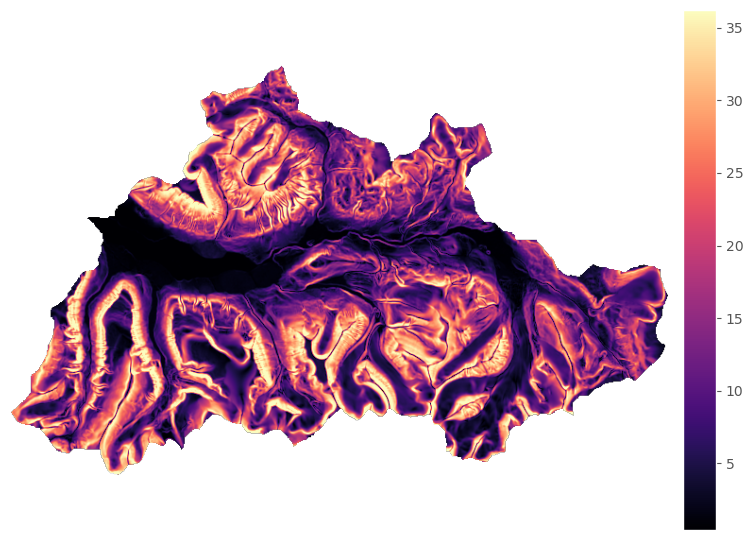

In [7]:
gdal_res = gdal.DEMProcessing(
    slp_path,
    dem_clip_path,
    "slope",
    alg="Horn",  # 'Horn' or 'ZevenbergenThorne'
    slopeFormat="degree",  # 'degree' or 'percent'
    creationOptions=["compress=lzw", "BIGTIFF=YES", "tiled=True"],
)
gdal_res.FlushCache()
gdal_res = None

slope = rd.LoadGDAL(slp_path)
rd.rdShow(slope, axes=False, cmap="magma", figsize=(8, 5.5));

## 5. Aspect

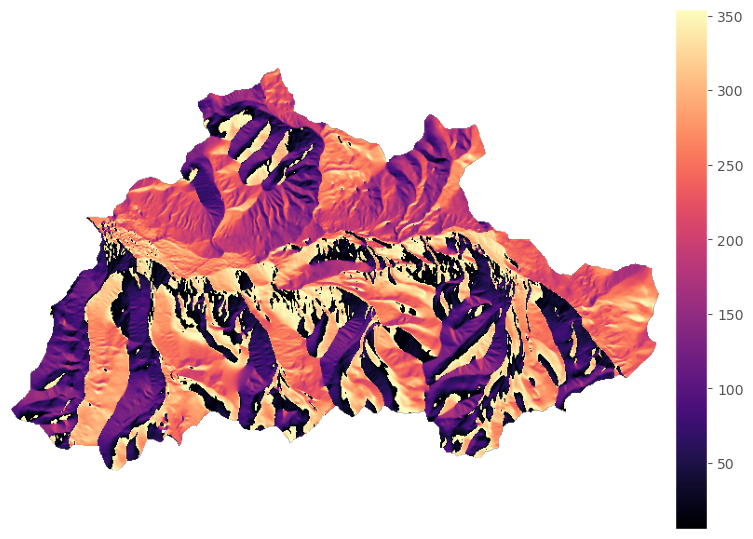

In [8]:
gdal_res = gdal.DEMProcessing(
    asp_path,
    dem_clip_path,
    "aspect",
    alg="Horn",  # 'Horn' or 'ZevenbergenThorne'
    zeroForFlat=False,  # Whether to return 0 for flat areas with slope=0, instead of -9999
    creationOptions=["compress=lzw", "BIGTIFF=YES", "tiled=True"],
)
gdal_res.FlushCache()
gdal_res = None

aspect = rd.LoadGDAL(asp_path, no_data=-9999)
rd.rdShow(aspect, axes=False, cmap="magma", figsize=(8, 5.5));

## 6. Curvature

I.e. slope of slope.

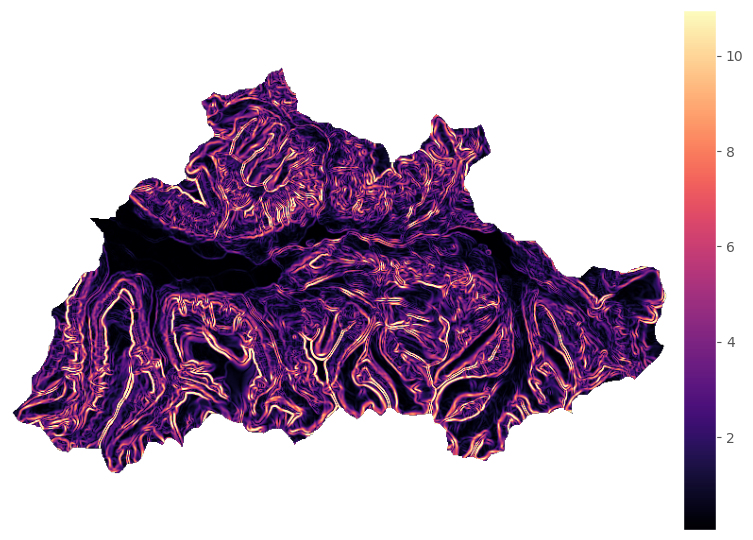

In [9]:
gdal_res = gdal.DEMProcessing(
    cur_path,
    slp_path,
    "slope",
    alg="Horn",  # 'Horn' or 'ZevenbergenThorne'
    slopeFormat="degree",  # 'degree' or 'percent'
    creationOptions=["compress=lzw", "BIGTIFF=YES", "tiled=True"],
)
gdal_res.FlushCache()
gdal_res = None

curve = rd.LoadGDAL(cur_path)
rd.rdShow(curve, axes=False, cmap="magma", figsize=(8, 5.5));

## 7. Slope of aspect (SOA)

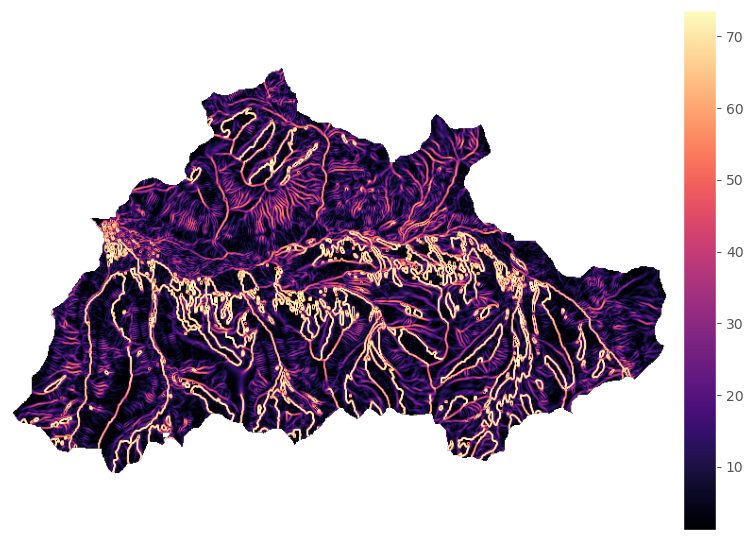

In [10]:
gdal_res = gdal.DEMProcessing(
    soa_path,
    asp_path,
    "slope",
    alg="Horn",  # 'Horn' or 'ZevenbergenThorne'
    slopeFormat="degree",  # 'degree' or 'percent'
    creationOptions=["compress=lzw", "BIGTIFF=YES", "tiled=True"],
)
gdal_res.FlushCache()
gdal_res = None

soa = rd.LoadGDAL(soa_path)
rd.rdShow(soa, axes=False, cmap="magma", figsize=(8, 5.5));

## 8. ECDFs

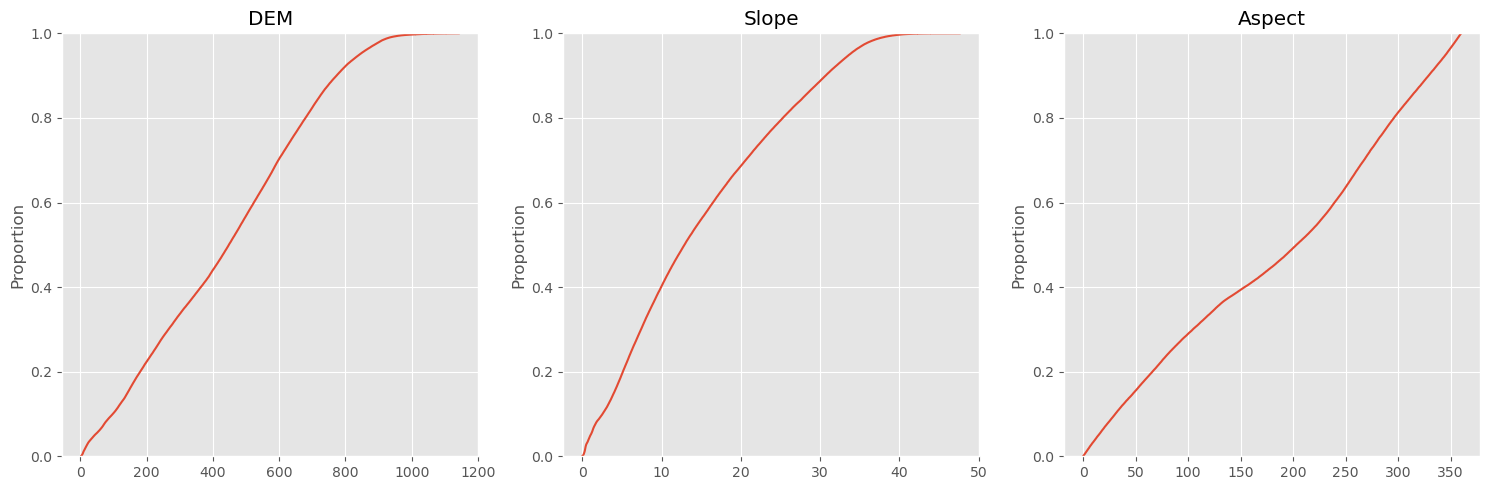

In [11]:
data_dict = {"DEM": dem, "Slope": slope, "Aspect": aspect}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for idx, (key, item) in enumerate(data_dict.items()):
    vals = item.flatten()
    vals = vals[vals >= 0]
    sn.ecdfplot(vals, ax=axes[idx])
    axes[idx].set_title(key)
plt.tight_layout()

## 9. Terrain masking

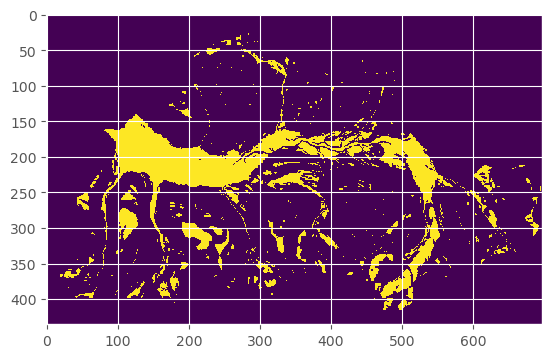

In [12]:
# Plot areas where slope < some threshold
slope_thresh = 5

mask = (slope >= 0) & (slope < slope_thresh)
plt.imshow(mask, interpolation="nearest")

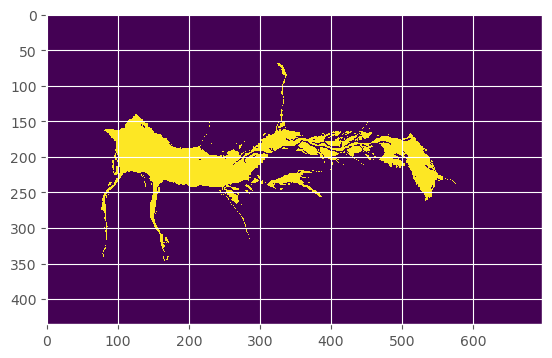

In [13]:
# Plot areas where slope < some threshold AND elevation < some threshold
slope_thresh = 5
elev_thresh = 200

mask = (slope >= 0) & (slope < slope_thresh) & (dem > 0) & (dem < elev_thresh)
plt.imshow(mask, interpolation="nearest")

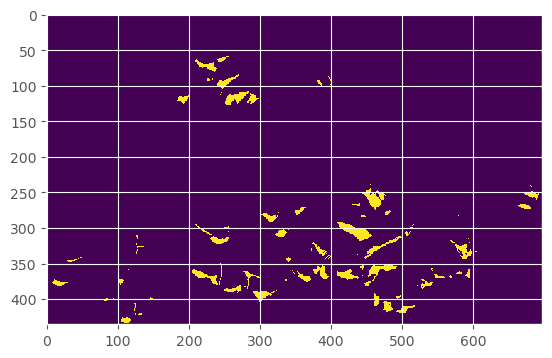

In [14]:
# Find all N-facing slopes above 700 m
mask = (((aspect >= 315) & (aspect < 360)) | ((aspect >= 0) & (aspect < 45))) & (
    dem > 700
)
plt.imshow(mask, interpolation="nearest")

In [15]:
# Save a mask (e.g. for visualisation in GIS)
out_tif = r"/home/jovyan/shared/common/LJB/svalbard/raster/n-facing_above_700m.tif"
save_array(mask, ds, out_tif, -9999, 0, dtype="uint8")